In [1]:
import numpy                    as np
import scipy.io.wavfile         as wav
import matplotlib.pyplot        as plt
import sklearn.decomposition    as skd
import math
import numpy.linalg as la

In [2]:
def spectrogram(signal, ws = 1024, hs = 512):
    # Author: C. Howard
    # Function to compute the baseline complex valued spectrogram for some input sound signal.
    # signal: a sound represented as a column vector
    # ws    : the window size
    # hs    : the hope size, aka the amount we shift from sample to sample

    # compute Hamming weights
    alpha   = 0.54
    beta    = 1 - alpha
    pi2     = 2.0*math.pi
    c       = pi2/(ws-1)
    w       = alpha - beta * np.cos(c*np.arange(0,ws,1))

    # compute DFT matrix
    p = np.arange(0,ws,1).reshape(ws,1)
    F = np.exp( -(pi2/ws)*np.matmul(p,p.T)*1j )  / np.sqrt(ws)

    # compute resulting local matrix
    D = np.multiply(F,w)

    # Compute number of samples in spectrogram
    (len,c)     = signal.shape
    num_samples = math.floor((len - hs)/(ws - hs))

    # initialize output S
    S = np.zeros((ws,num_samples),dtype=type(F[0,0]))

    # loop through and construct S
    for i in range(0,num_samples):
        S[:ws, i] = np.matmul(D,signal[i*hs:(i*hs+ws),0])

    # return the output spectrogram
    return S[:int(ws/2),:]

In [3]:
def pca(centeredData, numOfComponents):
    [U,s,Vt] = la.svd(centeredData)
    Uk = U[:,:numOfComponents]
    sk = s[:numOfComponents]
    Wp = np.diag(sk**-0.5) @ Uk.T
    return Wp

In [4]:
def ICA(Zp, thresh=50, alpha=1e-5):
    k, n = np.shape(Zp)
    W = np.eye(k)
    y = W @ Zp
    M, N = np.shape(y)
    mag_dW = thresh *100
    i = 0
    while (mag_dW > thresh):
        gradW = ((N*np.eye(k) - 2 * np.tanh(y) @ y.T)) @ W
        newW = W + alpha * gradW
        mag_dW = np.linalg.norm(gradW)
        W = newW
        y = W @ Zp
        if(i%100 == 0):
            print(mag_dW)
        i+=1
    return W

In [5]:
def nmf(X, tol=.001, max_iter=5000, n_components=3):

    # Random initialization of weights
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # A very big number for initial error
    oldlim = 1e5

    # A very small number to ensure matrices are strictly positive
    eps = 1e-7
    
    
    for i in range(max_iter):
      
        # Multiplicative update steps
        H = H * ((W.T.dot(X) + eps) / (W.T.dot(W).dot(H) + eps))
        W = W * ((X.dot(H.T) + eps) / (W.dot(H.dot(H.T)) + eps))

        # Frobenius distance between WH and X
        lim = np.linalg.norm(X-W.dot(H), 'fro')
        print(abs(oldlim - lim))
        # Check for convergence
        if abs(oldlim - lim) < tol:
            break

        oldlim = lim
        
    return W,H

In [6]:
# define the number of features you want
num_features    = 3

# load the sound file and get into proper shape
(freq,signal)   = wav.read('../data/vl1.wav')
N               = signal.shape[0]
signal          = signal.reshape(N,1)

In [7]:
window_size     = 1024
hop_size        = int(window_size/4)
S               = spectrogram(signal,ws=window_size,hs=hop_size)

In [8]:
# find the sqrt of the magnitude of the spectrogram matrix
(r,c)           = S.shape
Sn              = np.abs(S)
Snsq            = np.sqrt(Sn)

# compute mean of spectrogram data
mu_s            = np.matmul(Sn,np.ones((c,1))/c)

# subtract mean from data
Sn_d            = Sn - mu_s

# Perform PCA from zero-mean form of data
principalComponents   = pca(Sn_d,num_features)

In [9]:
# perform ICA

pcaProj = principalComponents @ Sn_d
W = ICA(pcaProj) @ pcaProj
Wnmf, Hnmf = nmf(Sn)

13265.797975572237
219.05244972144416
63.08129807876864
310234.1518942031
31607.125123275327
14140.536584543763
19834.51866525167
33348.498398230586
30056.85872651101
14484.486270435096
5433.2517862098175
2546.075234153279
1568.78560020437
1133.7753277027223
893.156260943797
738.1501323416014
623.9834567094513
530.1159635384975
450.0873481488088
383.32059416081756
330.51714617578546
292.1532163132797
268.4397347669874
259.6422915069561
266.2425990108168
288.9611699223751
328.60892356125987
385.69856301884283
459.81316574075026
548.8268086460303
648.2360617743107
751.0775490926462
849.017583997047
934.9180485153047
1006.34322672282
1068.5234092981264
1135.2504575744679
1227.4745111213415
1370.8813312911661
1593.8543705853517
1925.808780092455
2394.433889744483
3020.98037290317
3816.6089111448673
4784.981092372123
5920.022822577826
7154.832568817103
8249.237322621862
8780.265674918628
8484.991731382557
7625.176534368831
6606.506247635174
5574.608912162657
4543.641500983271
3386.223843858

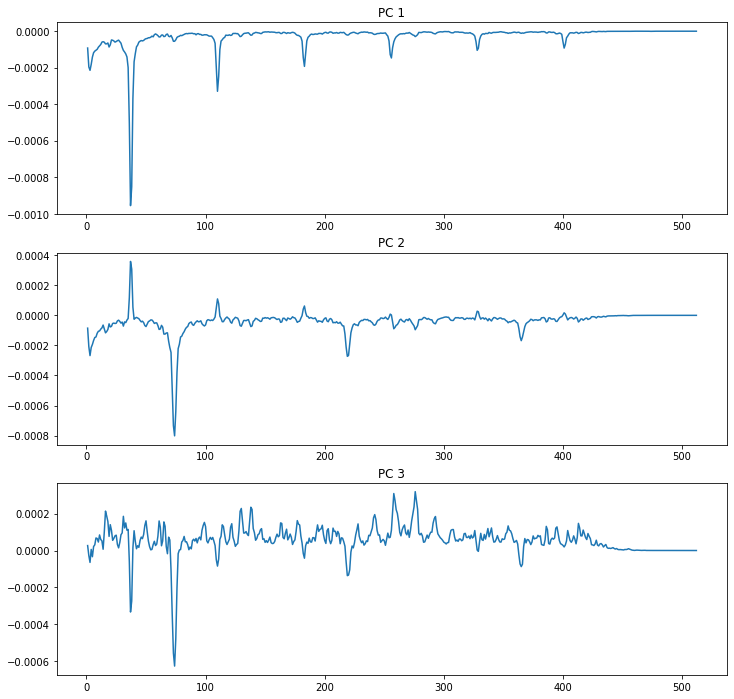

In [16]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot(ind, principalComponents.T[:, k])
    ax1[k].set_title('PC '+str(k+1))
fig.set_figheight(12)
fig.set_figwidth(12) 

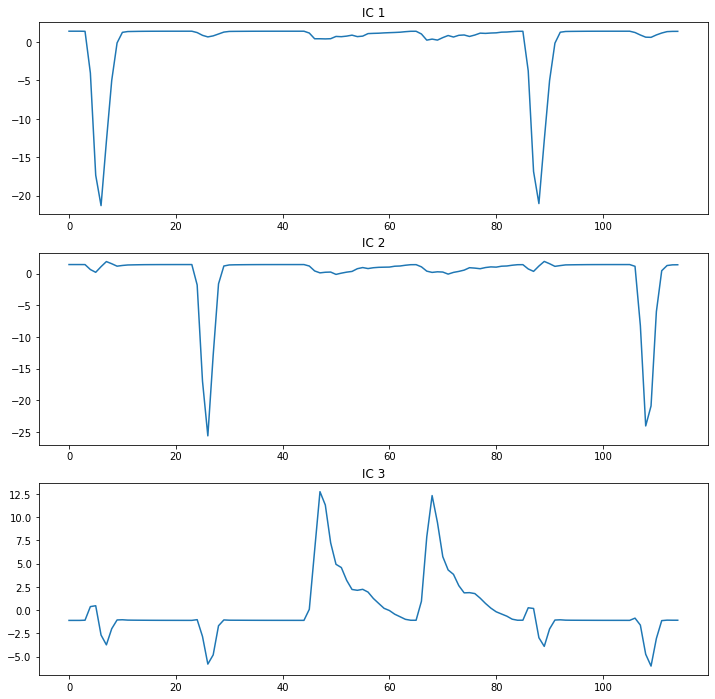

In [17]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( W.T[:, k])
    ax1[k].set_title('IC '+str(k+1))
fig.set_figheight(12)
fig.set_figwidth(12) 

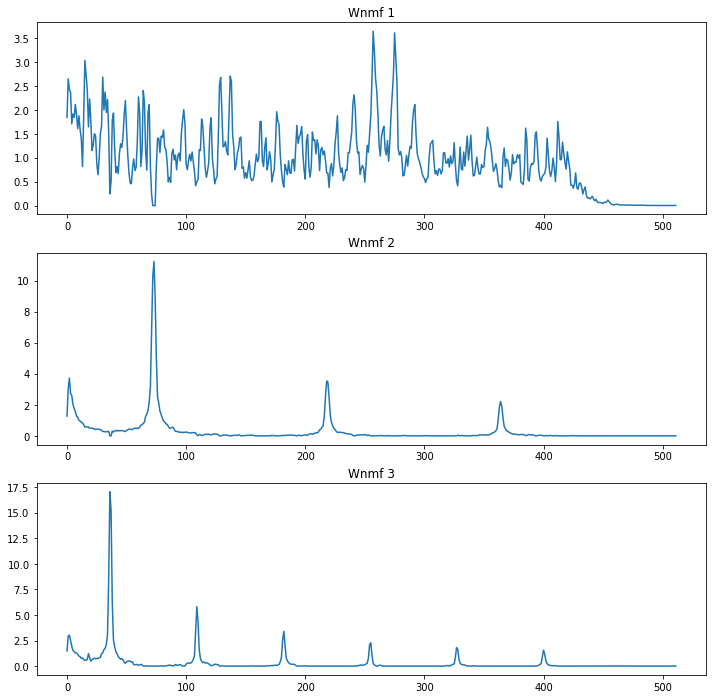

In [18]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Wnmf[:, k])
    ax1[k].set_title('Wnmf '+str(k+1))
fig.set_figheight(12)
fig.set_figwidth(12)

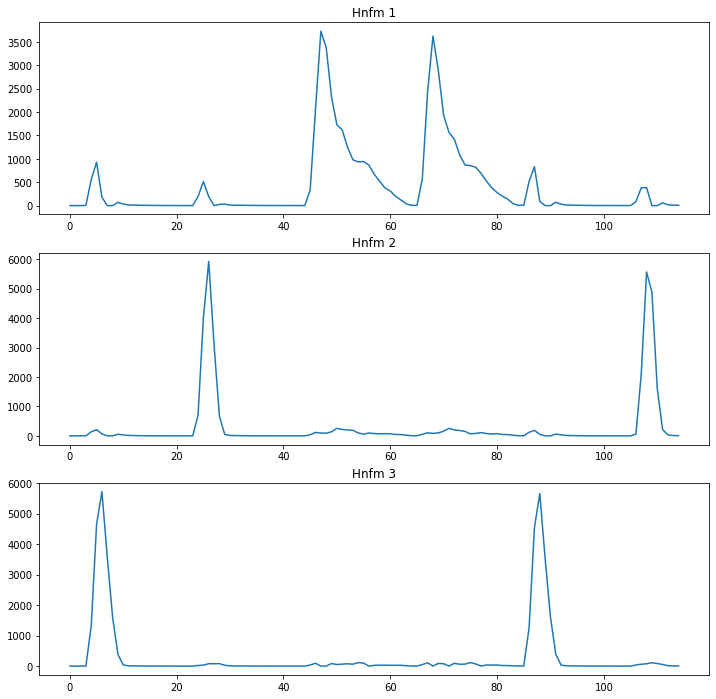

In [20]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Hnmf.T[:, k])
    ax1[k].set_title('Hnfm '+str(k+1))
fig.set_figheight(12)
fig.set_figwidth(12)

NameError: name 'n' is not defined